# Import libraries

In [33]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
rng = np.random.default_rng() # random number generator

# The Metapopulation Model

In this notebook, we will explore the steps to develop a stochastic metapopulation model based on binomial and multinomial extractions. We will proceed in four steps:
1. Define the disease parameters, specify the patches (subpopulations) information, and provide details about how many individuals travel between patches.
2. Simulate the spreading in a single patch.
3. Simulate the movement of individuals between patches.
4. Combine steps 2 and 3.

![SEIR Model](https://upload.wikimedia.org/wikipedia/commons/3/3d/SEIR.PNG)


# 1) Set disease parameters, population and travel

In [9]:
# SEIR disease parameters
beta = 0.5  # Infection rate
eps = 0.2   # Transition rate from E to I
mu = 0.2    # Transition rate from I to R

In [10]:
# Define population dataset
population = [1e6, 2e6, 1e5]  # List of population sizes
namePatches = [f'patch {I}' for I in range(len(population))]  # Generate patch names

# Combine population and namePatches into a DataFrame
populations = pd.DataFrame(zip(population, namePatches), columns=['pop', 'name'])  
populations

,pop,name
0,1000000.0,patch 0
1,2000000.0,patch 1
2,100000.0,patch 2


In [11]:
# Define travel dataset
# We assume symmetric travel, conserving population in each patch
# We need to specify only one direction of travel

travels = pd.DataFrame([[0, 1, 200], [1, 2, 300]], columns=['from', 'to', 'passengers']).set_index(['from', 'to'])
travels

,,passengers
from,to,
0,1,200
1,2,300


# 2) Simulate the disease

## SEIR Model

To simulate the compartments:
- We create a 3D array (initialized with zeros) called `comp` that will contain the number of individuals in each compartment for each patch and each time step of the simulation. We access it using `comp[simulationStep, patchNumber, compartment]`. For example, to access the number of exposed individuals at simulation step 20 in patch 1, use `comp[20, 1, 1]`.
- Similarly, we create another 3D array called `inc` with the same structure to account for the incidence in each compartment.

In [13]:
nameCompartments = ['S','E','I','R']
nCompartmens = 4
nPatches = len(populations)
nSteps = 200

# Create comp inc arrays
comp = np.zeros((nSteps, nPatches, nCompartmens), dtype=np.int64)
inc =  np.zeros((nSteps, nPatches, nCompartmens), dtype=np.int64)

In [16]:
# Fill comp array at time t=0, where all the population is in compartment S
...
comp[0,:,0] = populations['pop']

In [19]:
# Set initial conditions for the SEIR model
# At time 0, in patch 2, initialize one individual as exposed
initE = 10  
initPatch = 2 

# Update the compartments array for initial conditions
comp[0, initPatch, 1] += initE  # Move individuals from susceptible (compartment 0) to exposed (compartment 1)
comp[0, initPatch, 0] -= initE  # Decrease the number of susceptible individuals accordingly

# Update the incidence array to reflect initial exposure
inc[0, initPatch, 1] += initE 

# Check the state of compartments at time 0 across all patches
comp[0, :, :]

array([[1000000,       0,       0,       0],
       [2000000,       0,       0,       0],
       [  99980,      20,       0,       0]])

In [18]:
def transitions(comp, inc, fromCompartment, toCompartment, rate, step):
    '''
    This function modifies the arrays `comp` (compartment occupancy for each patch) and `inc` (compartment incidence for each patch).
    It updates the values at the given `step` to account for the transition between compartments based on binomial extractions.
    It assumes the comp array at `step` is filled with the values of the comp array at `step-1`.

    Parameters:
    - comp: 3D array, compartment occupancy for each patch over time
    - inc: 3D array, compartment incidence for each patch over time
    - fromCompartment: int, index of the compartment transitioning from
    - toCompartment: int, index of the compartment transitioning to
    - rate: float or array-like, transition rate or rates for each patch
    - step: int, current time step of the simulation

    Example:
    transitions(comp, inc, 1, 2, eps, 20) --> transitions from compartment 1 (E) to compartment 2 (I) with rate eps at time step 20
    '''
    
    transitions = rng.binomial(comp[step-1, :, fromCompartment], 1-np.exp(-rate))
    
    comp[step, :, toCompartment] += transitions
    comp[step, :, fromCompartment] -= transitions

    inc[step, :, toCompartment] += transitions

In [20]:
# For each step of the epidemic, update the transitions between compartments
for currentStep in np.arange(1, nSteps): 
    # Copy the compartment occupancy from the last step to the current step
    comp[currentStep, :, :] = comp[currentStep-1, :, :]

    # Perform spontaneous transitions
    # Transition from exposed (E) to infectious (I)
    transitions(comp=comp, inc=inc, fromCompartment=1, toCompartment=2, rate=eps, step=currentStep)
    
    # Transition from infectious (I) to recovered (R)
    transitions(comp=comp, inc=inc, fromCompartment=2, toCompartment=3, rate=mu, step=currentStep)

    # Perform mediated transition from susceptible (S) to exposed (E)
    mediatedRate = beta * comp[currentStep-1, :, 2] / comp[currentStep-1, :, :].sum(axis=1)
    transitions(comp=comp, inc=inc, fromCompartment=0, toCompartment=1, rate=mediatedRate, step=currentStep)

Text(0.5, 0, 'Time Step')

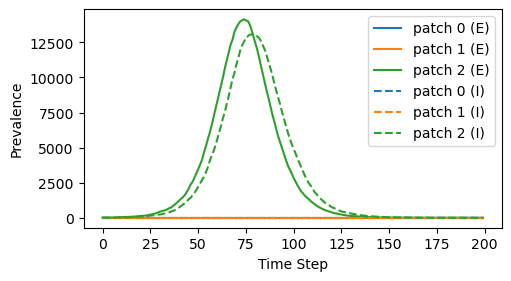

In [21]:
# Plot the prevalence of infection (I) and prevalence of exposure (E):
fig, ax = plt.subplots(figsize=(5, 2.7), layout='constrained')

for indexCompartment, style in zip([1, 2], ['-', '--']): 
    for patchIndex, patchName in enumerate(namePatches):
        label = f'{patchName} ({nameCompartments[indexCompartment]})'
        ax.plot(comp[:, patchIndex, indexCompartment], linestyle=style, label=label, color=f'C{patchIndex}')
        
plt.legend()
plt.ylabel('Prevalence')
plt.xlabel('Time Step')

# 3) Simulate human mobility

In [22]:
populations

,pop,name
0,1000000.0,patch 0
1,2000000.0,patch 1
2,100000.0,patch 2


In [23]:
travels

,,passengers
from,to,
0,1,200
1,2,300


In [24]:
# Here we create the travelsMatrix that contains the probability of individuals moving between patches
# The diagonal represents the probability of individuals staying in their respective patches

# Since travel is symmetric and we specified only one direction, we need to duplicate the passengers for the other direction
travelsMatrix = pd.concat([travels, travels.rename_axis(['to', 'from']).reorder_levels((1, 0))])

# Convert from a dataframe to a matrix form
travelsMatrix = travelsMatrix.unstack().fillna(0)
travelsMatrix = travelsMatrix.sort_index(axis=1).sort_index(axis=1)

# Fill diagonal with the population that do not travel
np.fill_diagonal(travelsMatrix.values, populations['pop'] - travelsMatrix.sum(1))

# Divide by population to convert passenger counts to probabilities of travel
travelsMatrix = travelsMatrix.divide(populations['pop'], axis=0)

travelsMatrix

passengers                  
to            0        1        2
from                             
0        0.9998  0.00020  0.00000
1        0.0001  0.99975  0.00015
2        0.0000  0.00300  0.99700

In [25]:
# Redefine all variables for a clean start
nameCompartments = ['S', 'E', 'I', 'R']
nCompartments = 4
nPatches = len(populations)
nSteps = 600

comp = np.zeros((nSteps, nPatches, nCompartments), dtype=np.int64)
inc = np.zeros((nSteps, nPatches, nCompartments), dtype=np.int64)
incT = np.zeros((nSteps, nPatches, nCompartments), dtype=np.int64)

comp[0, :, 0] = populations['pop'].values

In [26]:
# This snippet of code takes the travel probability matrix and computes for each patch and each compartment how many individuals travel to another patch
# It directly modifies the comp array 
for currentStep in np.arange(0, nSteps - 1): 
    comp[currentStep + 1, :, :] = rng.multinomial(comp[currentStep, :, :].T, travelsMatrix.values).T.sum(1)

## Plot the patch occupancy

Text(0.5, 0, 'steps')

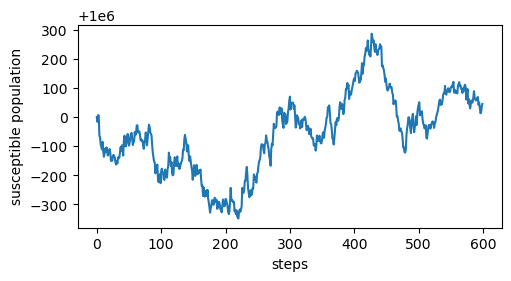

In [29]:
fig, ax = plt.subplots(figsize=(5, 2.7), layout='constrained')
ax.plot(comp[:,0,0])
ax.set_ylabel("susceptible population")
ax.set_xlabel("steps")

# 4) Metapopulation model
Here at each simulation step, we need to combine the two parts: simulate the disease and simulate human movement.

In [30]:
# Redefine all variables for a clean start
nameCompartments = ['S','E','I','R']
nCompartmens = 4
nPatches = len(populations)
nSteps = 200

# init arrays
comp = np.zeros((nSteps, nPatches, nCompartmens), dtype=np.int64)
inc =  np.zeros((nSteps, nPatches, nCompartmens), dtype=np.int64)
incT =  np.zeros((nSteps, nPatches, nCompartmens), dtype=np.int64)

comp[0,:,0] = populations['pop'].values

# initial condition
initE = 10
initPatch = 2 
comp[0,initPatch,1] += initE
comp[0,initPatch,0] -= initE
inc[0,initPatch,1] += initE

In [31]:
for currentStep in np.arange(1,nSteps): 
    # Travel step from 3)
    comp[currentStep,:,:] = rng.multinomial(comp[currentStep-1,:,:].T, travelsMatrix.values).T.sum(1)

    # Disease step from 2)
    transitions(comp=comp, inc=inc, fromCompartment=1, toCompartment=2, rate=eps, step=currentStep)
    transitions(comp=comp, inc=inc, fromCompartment=2, toCompartment=3, rate=mu, step=currentStep)
    mediatedRate = beta * comp[currentStep-1, :, 2] / comp[currentStep-1, :, :].sum(axis=1)
    transitions(comp=comp, inc=inc, fromCompartment=0, toCompartment=1, rate=mediatedRate, step=currentStep)

Text(0.5, 0, 'step')

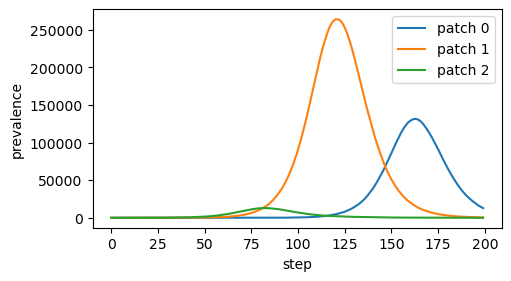

In [32]:
# Plot the prevalence of infection (I) and prevalence of exposure (E):
fig, ax = plt.subplots(figsize=(5, 2.7), layout='constrained')

for patchIndex, patchName in enumerate(namePatches):
    label = f'{namePatches[patchIndex]}'
    ax.plot(comp[:,patchIndex,2], label=label)

plt.legend()
plt.ylabel('prevalence')
plt.xlabel('step')